In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collatev2, compute_statistics
import winsound

from torchvision.ops import complete_box_iou, complete_box_iou_loss

In [2]:
import logging
logger = logging.getLogger('lex')
fh = logging.FileHandler('lex.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Define the bounding boxes
box1 = torch.tensor([[176.6819, 180.5027, 219.1436, 133.1604]])
box2 = torch.tensor([[153.5156, 123.0469, 179.2969, 148.8281]])

boxx1 = torch.stack([box1, box1])
boxx2 = torch.stack([box2, box2])

# Calculate IoU using torchvision's box_iou function
iou = complete_box_iou_loss(boxx1, boxx2).mean()
print(iou)

tensor(1.7371)


### Config for fitter

In [4]:
from project.model import RPN
image_size = 300
config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=image_size,
        nh=4
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 50,
    # 'loss': nn.MSELoss(),
    'loss': nn.SmoothL1Loss(),
    # 'loss': complete_box_iou_loss,
    'lr': 0.00001,
}

1369


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 5)

In [6]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,1,1
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,1,1
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,1,1
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,1,1
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,15,1,1
...,...,...,...,...,...
359,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1
360,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,26,1,1
361,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,24,1,1
362,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1


In [7]:
ch1 = ds.load_raw_mri(1)
data = data[data.mri.isin(ch1)]
data.shape

(45, 5)

### Train and Test Split

In [8]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    # random_state=12
)

data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [9]:
data_train.shape, data_test.shape

((36, 5), (9, 5))

In [10]:
cases = data.mri
masks = data.masks
target = data.target

global_min, global_max = compute_statistics(data_train.mri.tolist())

# global_min = 0.0
# global_max = 1417.92822265625

In [11]:
global_min, global_max

(0.0, 1417.92822265625)

In [12]:
transform = NiftiToTensorTransform(
    target_shape = (image_size, image_size), 
    rpn_mode=True,
    normalization=(global_min, global_max)
)

In [13]:
train_set = VALDODataset(
    cases=data_train.mri,
    masks=data_train.masks,
    target=data_train.target,
    transform=transform,
)

val_set = VALDODataset(
    cases=data_test.mri,
    masks=data_test.masks,
    target=data_test.target,
    transform=transform,
)

batch_size = 20

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=collatev2,
)

val_loader = DataLoader(
    val_set,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=collatev2,
)

### Fitter

In [14]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                num_slices = slices.shape[0]
                x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)

                for i in range(masks.shape[0]):
                    masks[i][0] = masks[i][0] / image_size
                    if any(num < 0 for num in masks[i][0]):
                        print(masks[i][0])
                # print(masks.shape)
                # print(masks)
                # break
                y = self.model(x, target)
                # logger.info(f'MEMORY after X, Y, T to device\t{memcheck()}')
                logger.info(f'Prediction: {y * image_size}, Original: {masks[target] * image_size}')
                Y.append(y)
                T.append(masks[target])
                # memcheck()
                # del x, y, masks, slices
                # torch.cuda.empty_cache()
                # memcheck()
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            # losses += self.loss[1](torch.stack(Y), torch.stack(T), reduction='mean')
            # print(losses)
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += len(batch)
            if counter % 100 == 0:
                logger.info(f'Progress:\t{counter}/{len(train_set)}')
                logger.info(f'Current error:\t{losses}')
            loss_history.append(losses.detach().cpu().numpy())
            
        return loss_history
    
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/image_size
                    y = self.model(x, target)
                    Y.append(y)
                    T.append(masks[target])
                losses = self.loss(torch.stack(Y), torch.stack(T))
                # losses += self.loss[1](torch.stack(Y), torch.stack(T), reduction='mean')
                loss_history.append(losses.cpu().numpy())
        return loss_history

In [15]:
fitter = RPNFitter(config)

### Training

In [16]:
try:
    thist, vhist = fitter.fit(train_loader, val_loader)
except Exception as e:
    winsound.Beep(500, 500)
    print(e)

EPOCH 0 ==============================


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


EPOCH 1 ==============================
EPOCH 2 ==============================
EPOCH 3 ==============================
EPOCH 4 ==============================
EPOCH 5 ==============================
EPOCH 6 ==============================
EPOCH 7 ==============================
EPOCH 8 ==============================
EPOCH 9 ==============================
EPOCH 10 ==============================
EPOCH 11 ==============================
EPOCH 12 ==============================
EPOCH 13 ==============================
EPOCH 14 ==============================
EPOCH 15 ==============================
EPOCH 16 ==============================
EPOCH 17 ==============================
EPOCH 18 ==============================
EPOCH 19 ==============================
EPOCH 20 ==============================
EPOCH 21 ==============================
EPOCH 22 ==============================
EPOCH 23 ==============================
EPOCH 24 ==============================
EPOCH 25 ==============================
EPOCH 26 

In [17]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

In [18]:
# import seaborn as sns
# import numpy as np

# sns.lineplot(torch.tensor(np.array(hist)).view(-1))
# torch.tensor(np.array(hist)).mean()

### Line Plot by epoch mean

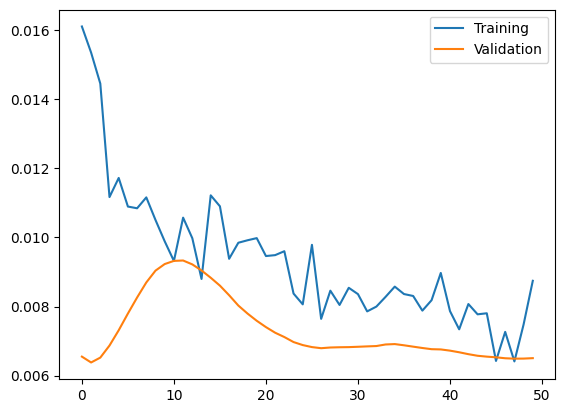

In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1), label='Training')
sns.lineplot(vh.mean(1), label='Validation')
plt.legend()
plt.show()

### Save the weights

In [20]:
import datetime

s = f'test_weights/RPN_test_normalizations_weights_{datetime.datetime.now().strftime("%d%m%y%H%M%S")}.pt'
s

'test_weights/RPN_test_normalizations_weights_281024113758.pt'

In [21]:
model = config['model']

In [22]:
torch.save(model.state_dict(), s)

# Summary

Performance of self-made embedder is a bit better compared to the pretrained embedder. Might work better if self-made embedder is also pretrained

### Next goals
- train embedder with an autoencoder setup

# Trial

In [39]:
model = fitter.model
# model = model.load_state_dict(torch.load('RPN_test_normalizations_weights_261024010615.pt'))

In [40]:
sample = next(enumerate(val_loader))

In [41]:
slices, masks, target, case = sample[1][1]

In [42]:
masks[target]

tensor([[[117.7734, 127.1484, 134.1797, 143.5547]]], dtype=torch.float64)

In [43]:
num_slices = slices.shape[0]
num_slices

35

In [44]:
x = slices.squeeze(1).float().to(device)
T = masks.squeeze(1).float().to(device)

In [45]:
y = model(x, target)

In [46]:
fitter.loss(y, T[target])

tensor(129.7041, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [47]:
losses = fitter.loss(y, T[target])
# losses += fitter.loss[1](y, T[target], reduction='mean')
losses

tensor(129.7041, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [48]:
y

tensor([[0.3928, 0.4076, 0.5147, 0.5246]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [49]:
masks[target]

tensor([[[117.7734, 127.1484, 134.1797, 143.5547]]], dtype=torch.float64)

In [50]:
y[0].detach().cpu().numpy() * 300 

array([117.850494, 122.29054 , 154.40408 , 157.37988 ], dtype=float32)

In [51]:
target

18

In [52]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

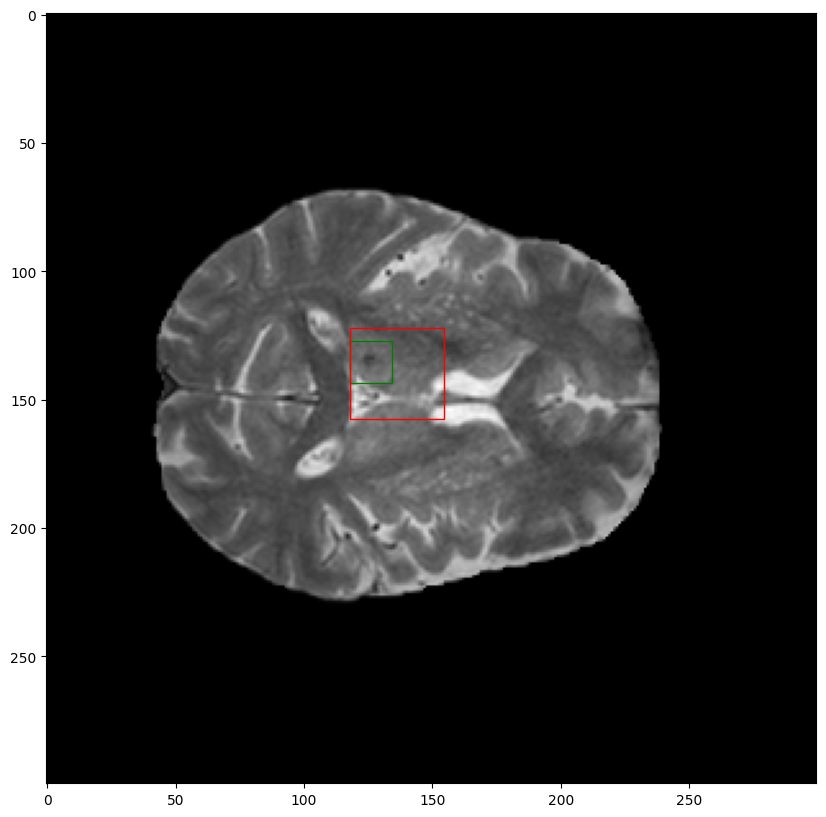

In [53]:
original_bbox = masks[target][0][0] # b_box
predicted_bbox = y[0].detach().cpu().numpy() * 300

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(slices[target][0, 0, :], cmap='gray')
# Create the bounding box rectangle
original_rect = patches.Rectangle(
    (original_bbox[0], original_bbox[1]),  # (x_min, y_min)
    original_bbox[2] - original_bbox[0],   # width
    original_bbox[3] - original_bbox[1],   # height
    linewidth=1, edgecolor='g', facecolor='none'  # red bounding box
)

# Create the bounding box rectangle
predicted_rect = patches.Rectangle(
    (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
    predicted_bbox[2] - predicted_bbox[0],   # width
    predicted_bbox[3] - predicted_bbox[1],   # height
    linewidth=1, edgecolor='r', facecolor='none'  # red bounding box
)

# Add the rectangle to the axis
ax.add_patch(original_rect)
ax.add_patch(predicted_rect)

In [54]:


# original_bbox = masks[target][0][0] # b_box
# predicted_bbox = y[0].detach().cpu().numpy() * 300

# img = slices

# num_slices = slices.shape[0] # Number of slices

# # Figure with numslices as rows and 3 columns
# fig, ax = plt.subplots(num_slices, 1, figsize=(10, num_slices * 2))

# for j in range(num_slices): 

#     # Plot label in secondf column
#     ax[j].imshow(img[j][0, 0, :], cmap='gray')
#     ax[j].set_title(f'Original Slice {j}')

#     # Create the bounding box rectangle
#     original_rect = patches.Rectangle(
#         (original_bbox[0], original_bbox[1]),  # (x_min, y_min)
#         original_bbox[2] - original_bbox[0],   # width
#         original_bbox[3] - original_bbox[1],   # height
#         linewidth=1, edgecolor='g', facecolor='none'  # red bounding box
#     )

#     # Create the bounding box rectangle
#     predicted_rect = patches.Rectangle(
#         (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
#         predicted_bbox[2] - predicted_bbox[0],   # width
#         predicted_bbox[3] - predicted_bbox[1],   # height
#         linewidth=1, edgecolor='r', facecolor='none'  # red bounding box
#     )

#     # Add the rectangle to the axis
#     ax[j].add_patch(original_rect)
#     ax[j].add_patch(predicted_rect)

# plt.show()